<h1 style="color:#444; font-size:2.5em;">Skill Connect: Week 1 - Advanced Challenge</h1>


# 1. Training Classification Algorithms

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace

sns.set(rc={'figure.figsize': (11, 8)})

# Data and Preprocessing

## Procurement and View

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context # Can't load data without this.

url_abalone_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
abalone_column = [
    "Sex", "Length", "Diameter", "Height", "Whole", "Shucked", "Viscera",
    "Shell", "Rings"
]
df = pd.read_csv(url_abalone_data, names=abalone_column)
df.head(5)

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


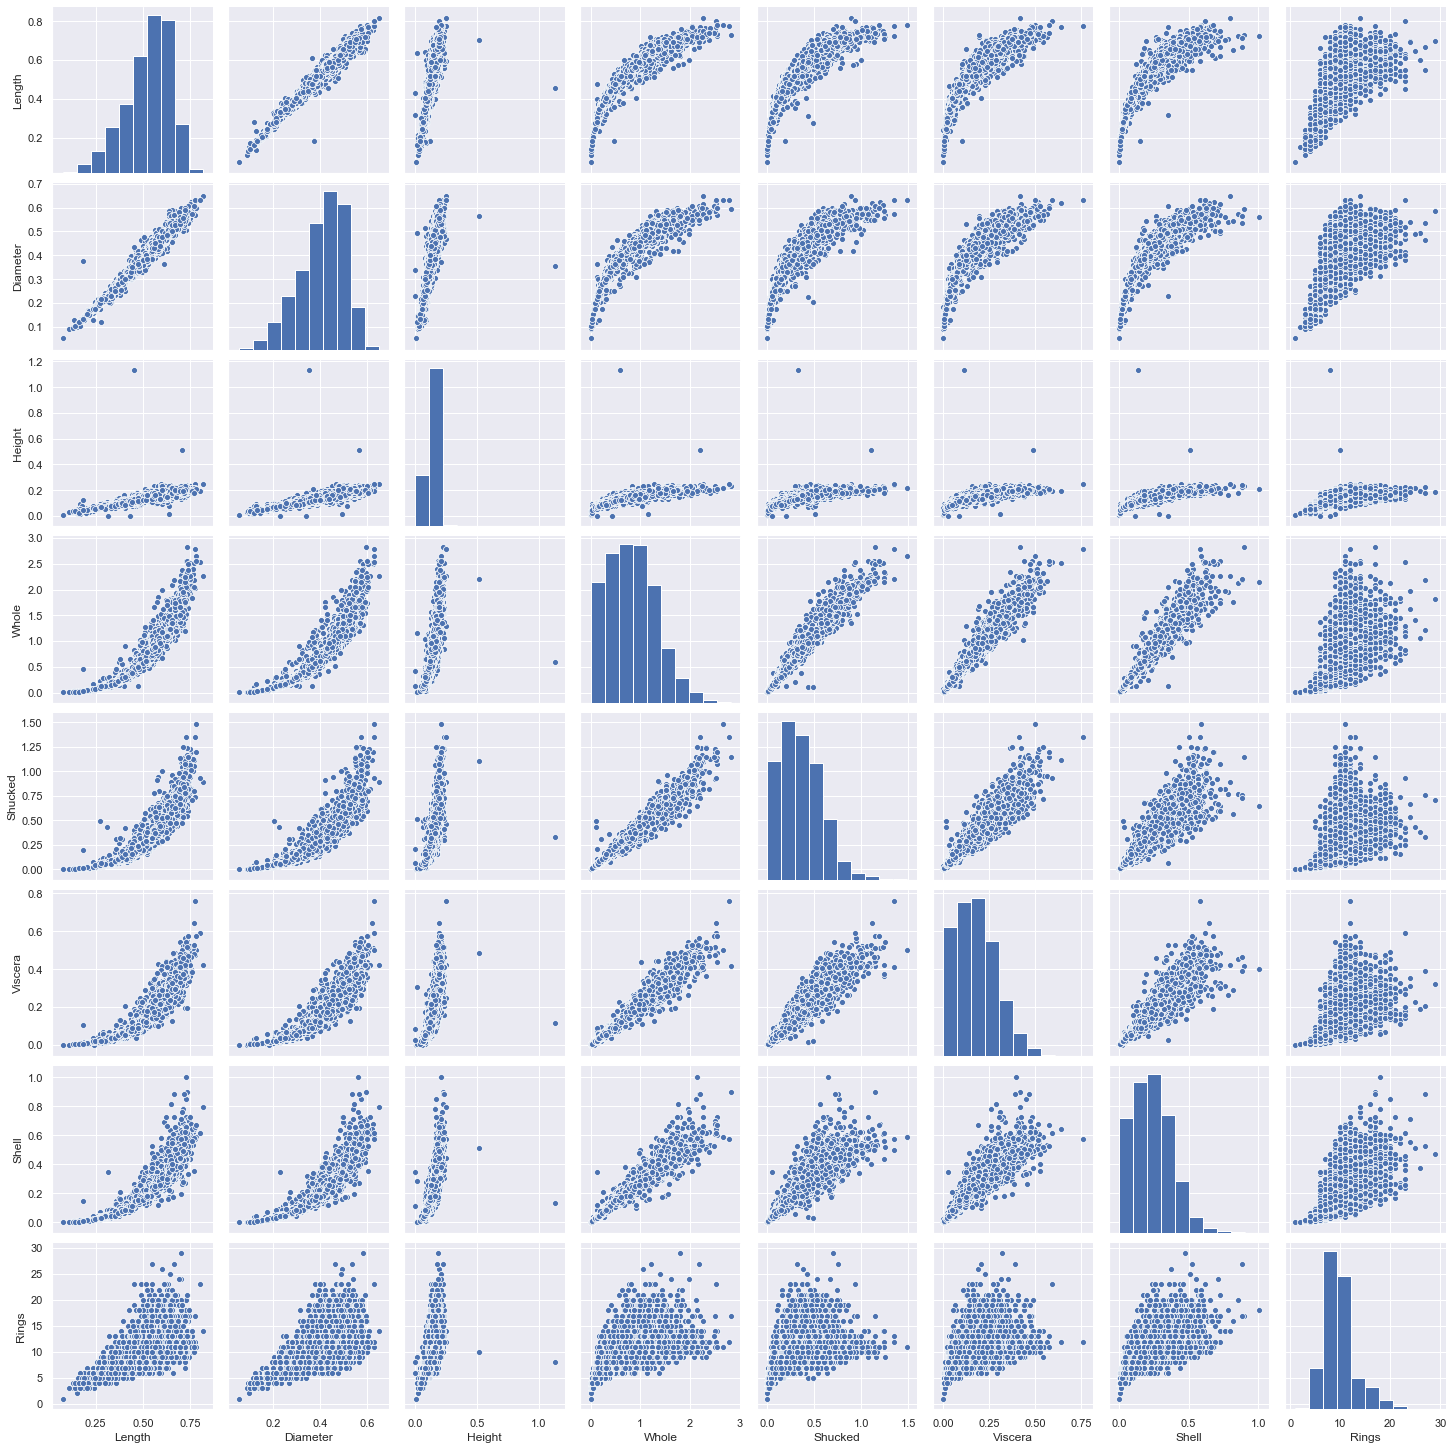

In [3]:
sns.pairplot(df)
plt.show()

1 1 15 57 115 259 391 568 689 634 487 267 203 126 103 67 58 42 32 26 14 6 9 2 1 1 2 1 

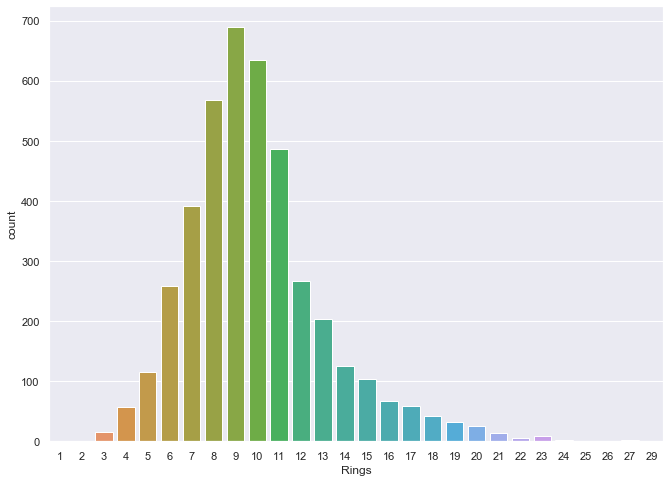

In [4]:
def show_count(df, cat):
    un = df[cat].unique()
    un.sort()
    _ = [print(f"{np.sum(df[cat]==un[i])}", end=' ') for i in range(len(un))]
    sns.countplot(x=df[cat])
    plt.show()
    
show_count(df, 'Rings')

## Preprocessing
One hot encoding the discrete 'Sex' feature.

In [5]:
def ohe(df, cat):
    """
    Function to one hot encode categorical data.
    """
    df = df.copy()
    for s in df[cat].unique():
        df[s] = np.int8(df[cat] == s)
    df.drop(cat, axis=1, inplace=True)
    return df


def normalize(X, mean=None, std=None):
    """
    Normalizes input by axis=0
    """
    mean = mean if mean is not None else X.mean(axis=0)
    std = std if std is not None else X.std(axis=0)
    return mean, std, (X - mean) / std

Combining classes because samples highly overlap.

In [6]:
def by_n(x,n):
    x["Rings"]//=n
    return x

# Group classes by three
df_mod = df.apply(by_n,axis=1,n=5)

# One hot encode 'Sex'
df_mod = ohe(df_mod, 'Sex')

# Dataframe to numpy arrays
y_all = df_mod['Rings'].to_numpy()
X_all = df_mod.drop(['Rings'], axis=1).to_numpy()

class_names = df_mod["Rings"].unique()
total_classes = len(class_names)
print(f"number of classes: {total_classes}")

df_mod.head(2)

number of classes: 6


,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings,M,F,I
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,3,1,0,0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,1,1,0,0


## Splitting
Into train (0.7), test (0.2) and valid (0.1).

In [7]:
class_target = np.arange(total_classes)
# Converts classnames (str) into indices.
to_target = np.vectorize(lambda x: np.argmax(class_names == x))
# Converts indices in y_* into class names.
to_classn = np.vectorize(lambda x: class_names[x])
# Splitting complete dataset into train and test sets.
X_tv, X_test, y_tv, y_test = train_test_split(X_all,
                                              y_all,
                                              test_size=0.2,
                                              stratify=y_all,
                                              random_state=34)

# Normalizing train data (non discrete features), saving mean, std for use with test.
mean_tv, std_tv, X_tv[:, :7] = normalize(X_tv[:, :7])

# Splitting train dataset into train and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(X_tv,
                                                      y_tv,
                                                      test_size=0.1,
                                                      stratify=y_tv,
                                                      random_state=34)

# Normalizing test data on train data mean and std
_, _, X_test[:, :7] = normalize(X_test[:, :7], mean_tv, std_tv)

# Note: all is a combination of train and validation sets
datasets = {
    "all": {
        "X": X_tv,
        "y": to_target(y_tv)
    },
    "train": {
        "X": X_train,
        "y": to_target(y_train)
    },
    "valid": {
        "X": X_valid,
        "y": to_target(y_valid)
    },
    "test": {
        "X": X_test,
        "y": to_target(y_test)
    }
}

# Constants
al = "all"
tr = "train"
va = "valid"
te = "test"
X = "X"
y = "y"


# Convenience function
def unravel(ds):
    return ds[tr][X], ds[tr][y], ds[te][X], ds[te][y], \
           ds[va][X], ds[va][y], ds[al][X], ds[al][y]


X_tr, y_tr, X_te, y_te, X_va, y_va, X_al, y_al = unravel(datasets)
for dset in datasets:
    print(f"{dset.ljust(5)} - ", end="")
    for var in datasets[dset]:
        print(f"{var}: {str(datasets[dset][var].shape).ljust(11)}", end="")
    print()

all   - X: (3341, 10) y: (3341,)    
train - X: (3006, 10) y: (3006,)    
valid - X: (335, 10)  y: (335,)     
test  - X: (836, 10)  y: (836,)     


# 1.1 Logistic Regression

Implementing a One vs. All classifier

## Self coded

In [8]:
from sklearn.preprocessing import PolynomialFeatures

### Helper functions

In [9]:
# Sigmoid function.
def sig(x,rsm=1e-8):
    s = np.vectorize(lambda x: 1 / (1 + np.exp(-x)))
    return np.clip(s(x),a_max=1-rsm,a_min=rsm)
    
# Initialize parameters.
def init_params(n: "input features", c: "classes"):
    return np.random.rand(c, n, 1)


# Hypothesis function gives P(y).
def hyp_func(X, params):
    return sig(X @ params)


# Calculate the l2 regularization term.
def l2_reg(params, lamb):
    return lamb * params[1:].T @ params[1:]


# Cross Entropy Loss.
def cse_loss(y_pred, y):
    assert y_pred.shape[1] == 1 and y.shape[1] == 1, "inconsistent shapes"
    return -1 * (y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))


# Cost function giving the mean loss.
def cse_cost(y_pred, y, params, lamb):
    return (cse_loss(y_pred, y).sum() + l2_reg(params, lamb)) / (2 * y.shape[0])


# Derivative of the Cross Entropy Loss
def cse_loss_der(y_pred, y, X, params, lamb):
    assert y_pred.shape[1] == 1 and y.shape[1] == 1, "inconsistent shapes"
    der = X.T @ (y_pred - y)
    der[1:] = der[1:] + lamb * params[1:]
    der = der / y.shape[0]
    assert der.shape[1] == 1, "inconsistent shape: X"
    return der


# Add polynomial features.
def add_poly(X):
    pf = PolynomialFeatures()
    return pf.fit_transform(X)


# ova: one vs. all
def get_ova_y(y, ind):
    return np.uint8(y == ind)


def get_ova_ys(y, c):
    return np.stack([get_ova_y(y, i) for i in range(c)]).reshape(c, -1, 1)

### Gradient Descent

In [10]:
def gradient_descent(X, y, params, lr, lamb, epochs, print_metrics):
    costs = []
    for i in range(epochs):
        y_pred = hyp_func(X, params)
        if print_metrics:
            cost = cse_cost(y_pred, y, params, lamb)
        costs.append(cost.item())
        derv = cse_loss_der(y_pred, y, X, params, lamb)
        params = params - lr * derv
    return params, costs

### Training `m` classifiers

In [11]:
def log_reg_learn(X, y, c=total_classes, lr=1e-2, lamb=1e-4, epochs=100, print_metrics=True):
    X = add_poly(X) # add polynomial features
    n = X.shape[1]  # input features.
    m = X.shape[0]  # number of samples.

    param = init_params(n, c)
    y_ova = get_ova_ys(y, c)

    for i in range(c):
        y_i = y_ova[i]
        p_i = param[i]
        param[i], costs = gradient_descent(X, y_i, p_i, lr, lamb, epochs, print_metrics)
        if print_metrics:
            costs = np.array(costs)
            #  One vs all accuracy.
            acc = (np.uint8(sig(X @ param[i]) > 0.5) == y_i).sum() / m
            print(f"{i:2d} -- acc {acc*100:0.2f}% -- costs - init:{costs[0]:0.3f} final:{costs[-1]:0.3f}")
    return param.reshape(c, n).T

def predict(X, params):
    X = add_poly(X)
    assert X.shape[1] == params.shape[0]
    return sig(X @ params).argmax(axis=1)

In [12]:
log_reg_params = log_reg_learn(X_tr, y_tr,lamb=1e-4,epochs=400)

 0 -- acc 84.20% -- costs - init:4.702 final:0.205
 1 -- acc 69.59% -- costs - init:2.793 final:0.309
 2 -- acc 67.96% -- costs - init:2.572 final:0.388
 3 -- acc 96.34% -- costs - init:4.263 final:0.114
 4 -- acc 97.27% -- costs - init:3.679 final:0.186
 5 -- acc 99.70% -- costs - init:4.794 final:0.064


In [13]:
acc_tr = (predict(X_tr,log_reg_params)==y_tr).sum()/X_tr.shape[0]
acc_te = (predict(X_te,log_reg_params)==y_te).sum()/X_te.shape[0]
print(f"accuracy -- train: {acc_tr*100:0.3f}%, test: {acc_te*100:0.3f}%")

accuracy -- train: 63.273%, test: 61.483%


## Using sklearn

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
def get_clf(X,y):
    X = add_poly(X)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X,y)
    return clf

def sk_pred(X,clf):
    X = add_poly(X)
    return clf.predict(X)

clf = get_clf(X_tr,y_tr)

In [16]:
acc_tr = (sk_pred(X_tr,clf)==y_tr).sum()/X_tr.shape[0]
acc_te = (sk_pred(X_te,clf)==y_te).sum()/X_te.shape[0]
print(f"accuracy -- train: {acc_tr*100:0.3f}%, test: {acc_te*100:0.3f}%")

accuracy -- train: 71.457%, test: 68.062%


# 1.2 Naive Bayes Classifier
Only sklearn

In [17]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
nb_clf.fit(X_al,y_al)
nb_train_acc = nb_clf.score(X_al,y_al)
nb_test_acc = nb_clf.score(X_te,y_te)

print(f"accuracy -- train: {nb_train_acc*100:0.3f}%, test: {nb_test_acc*100:0.3f}%")

accuracy -- train: 42.682%, test: 41.507%


# 1.3 k Nearest Neighbours

## 1.3.1 Self coded

In [18]:
def knn_predict(x, X_tr, y_tr, k):
    """
    Function that predicts for one sample.
    """
    # Calculate the distance to all refrence points.
    dists = np.linalg.norm(X_tr - x, axis=1)
    # Get indices of top k points.
    knn_indices = np.argpartition(dists, kth=k)[:k]
    # Return mode of classes.
    return mode(y_tr[knn_indices]).mode


def get_acc_knn(X_te, y_te, X_tr, y_tr, k):
    """
    Function that calculates accuracy using test.
    """
    samples = y_te.shape[0]
    pred = []
    for x in X_te:
        pred.append(knn_predict(x, X_tr, y_tr, k))
    pred = np.array(pred).reshape(-1)
    correct_pred = (pred == y_te.reshape(-1)).sum()
    return correct_pred / samples


def plot_k_vs_acc(datasets, upto):
    """
    Plot accuracy vs k values
    """
    
    X_tr,y_tr,X_te,y_te,X_va,y_va,X_al,y_al = unravel(datasets)
    
    r = range(1, upto)
    ks = list(r)
    acc = []
    # Checking accuracy against validation set.
    for k in r:
        acc.append(get_acc_knn(X_va, y_va, X_tr, y_tr, k) * 100)
    max_idx = np.argmax(acc)
    best_k = ks[max_idx]
    plt.plot(ks, acc, label='accuracy % vs. k')
    plt.legend()
    plt.show()
    
    # Accuracy for test set using 'best' k value.
    acc_te = get_acc_knn(X_te,y_te,X_tr,y_tr,best_k)
    print(f"max validation accuracy: {acc[max_idx]:0.4f} at k: {best_k}")
    print(f"test accuracy {acc_te*100:0.4f} at k: {best_k}")

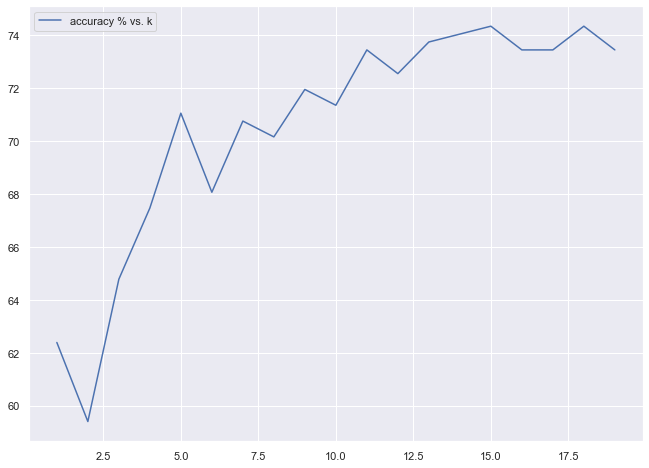

max validation accuracy: 74.3284 at k: 15
test accuracy 67.2249 at k: 15


In [19]:
plot_k_vs_acc(datasets, 20)

## 1.3.2 Using sklearn

In [20]:
from sklearn.neighbors import KNeighborsClassifier


def plot_k_vs_acc_sk(datasets, upto):
    """
    Plot accuracy vs k values using sklearn
    """
    X_tr,y_tr,X_te,y_te,X_va,y_va,X_al,y_al = unravel(datasets)
    
    r = range(1, upto)
    ks = list(r)
    acc = []
    for k in r:
        # Create classifier
        knn_clf = KNeighborsClassifier(n_neighbors=k)
        knn_clf.fit(X_tr, y_tr)

        # Predict
        knn_clf_pred = knn_clf.predict(X_va)
        correct = (knn_clf_pred == y_va).sum()
        tot = y_va.shape[0]
        acc.append((correct / tot) * 100)

    max_idx = np.argmax(acc)
    best_k = ks[max_idx]
    plt.plot(ks, acc, label='accuracy % vs. k')
    plt.legend()
    plt.show()
    
    knn_clf = KNeighborsClassifier(n_neighbors=best_k)
    knn_clf.fit(X_al, y_al)
    # Predict
    knn_clf_pred = knn_clf.predict(X_te)
    correct = (knn_clf_pred == y_te).sum()
    tot = y_te.shape[0]
    acc_te = (correct / tot)
    print(f"max validation accuracy: {acc[max_idx]:0.4f} at k: {best_k}")
    print(f"test accuracy {acc_te*100:0.4f} at k: {best_k}")

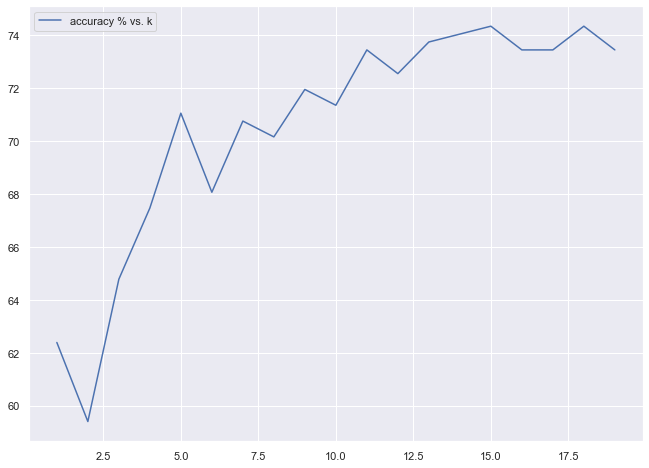

max validation accuracy: 74.3284 at k: 15
test accuracy 67.5837 at k: 15


In [21]:
plot_k_vs_acc_sk(datasets, 20)

# 1.4 Support Vector Machines
Only sklearn

In [22]:
from sklearn.svm import SVC

sv_clf = SVC()
sv_clf.fit(X_al,y_al)
sv_train_acc = sv_clf.score(X_al,y_al)
sv_test_acc = sv_clf.score(X_te,y_te)

print(f"accuracy -- train: {sv_train_acc*100:0.3f}%, test: {sv_test_acc*100:0.3f}%")

accuracy -- train: 71.386%, test: 69.617%


# 1.5 Decision Trees
Only sklearn

In [23]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(criterion="entropy",class_weight="balanced")
dt_clf.fit(X_al,y_al)
dt_train_acc = dt_clf.score(X_al,y_al)
dt_test_acc = dt_clf.score(X_te,y_te)

print(f"accuracy -- train: {dt_train_acc*100:0.3f}%, test: {dt_test_acc*100:0.3f}%")

accuracy -- train: 100.000%, test: 60.766%


# 1.6 Boosted Trees
Only sklearn

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_al,y_al)
gb_train_acc = gb_clf.score(X_al,y_al)
gb_test_acc = gb_clf.score(X_te,y_te)

print(f"accuracy -- train: {gb_train_acc*100:0.3f}%, test: {gb_test_acc*100:0.3f}%")

accuracy -- train: 81.323%, test: 67.105%


# 1.7 Random Forest
Only sklearn

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(criterion="entropy",)
rf_clf.fit(X_al,y_al)
rf_train_acc = rf_clf.score(X_al,y_al)
rf_test_acc = rf_clf.score(X_te,y_te)

print(f"accuracy -- train: {rf_train_acc*100:0.3f}%, test: {rf_test_acc*100:0.3f}%")

accuracy -- train: 100.000%, test: 67.703%


# 1.8 Neural Networks

## Using Pytorch

In [26]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

### Create DataLoaders

In [35]:
def get_dataloader(X,y, batch_size=64):
    tt = lambda d: torch.tensor(d)
    ds = TensorDataset(tt(X).float(), tt(y))
    return DataLoader(ds, batch_size=batch_size, drop_last=False,shuffle=True)

dl = {}
    
for dset in datasets:
    dl[dset] = get_dataloader(datasets[dset][X],datasets[dset][y])
    
for dset in dl:
    print(f"{dset.ljust(5)} - {len(dl[dset].dataset)}")

all   - 3341
train - 3006
valid - 335
test  - 836


### Define fit function

In [41]:
def check_accu_nn(model, dl):
    model.eval()
    accu = 0
    for X, y in dl:
        with torch.no_grad():
            y_pr = model(X)
            y_cl = y_pr.argmax(axis=1)
            accu += (y_cl == y).sum().item()
    return accu / len(dl.dataset)


def fit(dl_tr, dl_va, model, optimiser, loss_function, epochs, drop=False):
    torch.set_default_dtype(torch.float)
    losses = []
    sz = len(dl_tr.dataset)
    t1 = time.time()
    best_state = model.state_dict().copy()
    best_va_accu = 0.0

    for i in range(epochs):
        if (i + 1) % 100 == 0 and drop:
            for p in optimiser.param_groups:
                p['lr'] /= 5
                print(f"lr: {p['lr']}")
        r_loss = 0
        r_accu = 0
        for X_tr, y_tr in dl_tr:
            model.train()
            y_pr = model(X_tr)
            y_cl = y_pr.argmax(axis=1)

            optimiser.zero_grad()
            loss = loss_function(y_pr, y_tr)
            loss.backward()
            optimiser.step()

            with torch.no_grad():
                bs = len(y_tr)
                r_loss += loss.item() * bs
                r_accu += (y_tr == y_cl).sum().item()
        e_loss = r_loss / sz
        e_accu = r_accu / sz
        losses.append(e_loss)

        # Check accuracy of the model on validation set.
        va_accu = check_accu_nn(model, dl_va)
        if va_accu > best_va_accu:
            best_va_accu = va_accu
            best_state = deepcopy(model.state_dict())

#         if i % 10 == 0:
        t = time.time() - t1
        print(f"{i+1:3d}/{epochs} -- loss:{e_loss:0.3f} \
        te accu:{e_accu:0.3f} va accu:{va_accu:0.3f} -- \
        time: {t:0.3f}")

    print(f"best va accu:{best_va_accu:0.3f}")
    # Model with best validation accuracy is selected.
    model.load_state_dict(best_state)
    return losses

### Initialise network for training

In [58]:
in_features = len(df_mod.columns) - 1
out_features = len(df_mod['Rings'].unique())

# Model Definition
net = nn.Sequential(
    nn.Linear(in_features, 100), nn.ReLU(),
    nn.Linear(100, 1000), nn.ReLU(),
    nn.Linear(1000, 1000), nn.ReLU(),
    nn.Linear(1000, 1000), nn.ReLU(),
    nn.Linear(1000, 100), nn.ReLU(),
    nn.Linear(100, out_features)
)

loss_function = nn.CrossEntropyLoss()

In [59]:
optimiser = optim.Adam(lr=0.001,params=net.parameters(),weight_decay=1e-5)
losses = fit(dl[tr],dl[va],net,optimiser,loss_function, 30)

  1/30 -- loss:0.944         te accu:0.637 va accu:0.699 --         time: 1.179
  2/30 -- loss:0.734         te accu:0.689 va accu:0.740 --         time: 2.194
  3/30 -- loss:0.716         te accu:0.689 va accu:0.728 --         time: 3.157
  4/30 -- loss:0.697         te accu:0.710 va accu:0.696 --         time: 4.297
  5/30 -- loss:0.700         te accu:0.696 va accu:0.728 --         time: 5.319
  6/30 -- loss:0.690         te accu:0.703 va accu:0.716 --         time: 6.307
  7/30 -- loss:0.678         te accu:0.705 va accu:0.716 --         time: 7.533
  8/30 -- loss:0.685         te accu:0.712 va accu:0.728 --         time: 8.803
  9/30 -- loss:0.671         te accu:0.703 va accu:0.713 --         time: 9.860
 10/30 -- loss:0.660         te accu:0.711 va accu:0.725 --         time: 11.017
 11/30 -- loss:0.681         te accu:0.708 va accu:0.716 --         time: 12.273
 12/30 -- loss:0.659         te accu:0.717 va accu:0.699 --         time: 13.674
 13/30 -- loss:0.652         te accu:

In [60]:
nn_train_acc,nn_test_acc = check_accu_nn(net,dl[tr]), check_accu_nn(net,dl[te])
print(f"accuracy -- train: {nn_train_acc*100:0.3f}%, test: {nn_test_acc*100:0.3f}%")

accuracy -- train: 69.960%, test: 68.541%


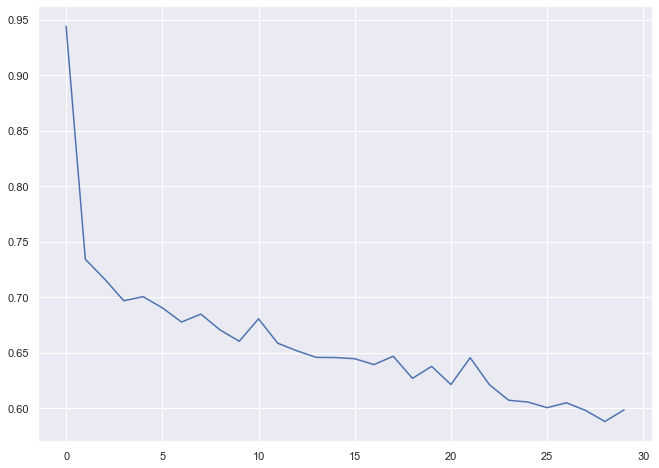

In [61]:
sns.lineplot(np.arange(len(losses)),losses)
plt.show()

## Using sklearn

In [56]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,1000,1000,1000,100),\
                        alpha=0.,batch_size=48,verbose=False, early_stopping=True,max_iter=30)
mlp_clf.fit(datasets[al][X], datasets[al][y])

MLPClassifier(activation='relu', alpha=0.0, batch_size=48, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100, 1000, 1000, 1000, 100),
              learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
              max_iter=30, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=None,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)

In [57]:
nn_train_acc = (mlp_clf.predict(datasets[tr][X]) == datasets[tr][y]).sum()/len(y_train)
nn_test_acc = (mlp_clf.predict(datasets[te][X]) == datasets[te][y]).sum()/len(y_train)
print(f"accuracy -- train: {nn_train_acc*100:0.3f}%, test: {nn_test_acc*100:0.3f}%")

accuracy -- train: 73.087%, test: 18.796%
